# 🦋 Butterfly Species Classification - Multi-Model Training
## Version 3.0 - Production Ready for Kaggle 2026

**Train & Compare 4 State-of-the-Art Models:**
1. 🏛️ **VGG16** - Classic deep architecture (138M params)
2. 🔗 **ResNet50** - Residual connections (25M params)
3. ⚡ **EfficientNetB0** - Compound scaling (5.3M params) - Usually wins!
4. 📱 **MobileNetV2** - Lightweight (3.5M params)

**Automatic Model Selection:** The notebook will train all 4 models and automatically select the best one!

**Expected Time:** ~100-120 minutes on Kaggle T4 GPU

**Expected Accuracy:** 85-88% (best model)

---

## 📦 Step 1: Import Libraries

**No installations needed!** Kaggle has everything pre-installed.

Those CUDA warnings are normal - just ignore them!

In [2]:
# Import all required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import os
import json
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display environment info
print("=" * 70)
print("ENVIRONMENT CHECK")
print("=" * 70)
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"sklearn: {sklearn.__version__}")
from platform import python_version
# print(python_version())
print(f"Python: {python_version()}")

print(f"\nGPU Devices: {tf.config.list_physical_devices('GPU')}")
print("="*70)
print("=" * 70)
print("\n✅ All libraries loaded successfully!")
print("✅ Ready to train 4 models!")

ENVIRONMENT CHECK
TensorFlow: 2.19.0
Keras: 3.10.0
NumPy: 2.0.2
Pandas: 2.2.2
sklearn: 1.6.1
Python: 3.12.12

GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

✅ All libraries loaded successfully!
✅ Ready to train 4 models!


## 📂 Step 2: Load Dataset

Make sure you've added the butterfly dataset to your notebook!

In [3]:
# Configure paths (Kaggle format)
DATASET_PATH = '/kaggle/input/butterfly-image-classification'
CSV_FILE = os.path.join(DATASET_PATH, 'Training_set.csv')
IMAGES_DIR = os.path.join(DATASET_PATH, 'train')

# Verify dataset exists
print("Checking dataset...")
print(f"CSV exists: {os.path.exists(CSV_FILE)}")
print(f"Images dir exists: {os.path.exists(IMAGES_DIR)}")

if not os.path.exists(CSV_FILE):
    raise FileNotFoundError(
        "Dataset not found! Please add 'butterfly-image-classification' dataset in Kaggle."
    )

# Load dataset
print("\nLoading dataset...")
df = pd.read_csv(CSV_FILE)
df['filepath'] = df['filename'].apply(lambda x: os.path.join(IMAGES_DIR, x))

# Verify all files exist
existing_files = df['filepath'].apply(os.path.exists)
print(f"Files found: {existing_files.sum()}/{len(df)} ({existing_files.sum()/len(df)*100:.1f}%)")

if not all(existing_files):
    print(f"⚠️ Warning: {(~existing_files).sum()} files missing. Removing from dataset.")
    df = df[existing_files].reset_index(drop=True)

# Dataset statistics
print(f"\n{'='*70}")
print("DATASET STATISTICS")
print(f"{'='*70}")
print(f"Total images: {len(df)}")
print(f"Number of species: {df['label'].nunique()}")
print(f"Images per species (avg): {len(df) / df['label'].nunique():.1f}")

# Class distribution
class_counts = df['label'].value_counts()
print(f"\nClass balance:")
print(f"  Min: {class_counts.min()} images")
print(f"  Max: {class_counts.max()} images")
print(f"  Mean: {class_counts.mean():.1f} images")
print(f"{'='*70}")

Checking dataset...
CSV exists: True
Images dir exists: True

Loading dataset...
Files found: 6499/6499 (100.0%)

DATASET STATISTICS
Total images: 6499
Number of species: 75
Images per species (avg): 86.7

Class balance:
  Min: 71 images
  Max: 131 images
  Mean: 86.7 images


## ✂️ Step 3: Train/Validation Split

Using 80/20 split with stratification to maintain class balance.

In [4]:
# Create stratified split
print("Creating train/validation split...")
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42  # Fixed seed for reproducibility
)

print(f"\n✅ Split created:")
print(f"Training set: {len(train_df)} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} images ({len(val_df)/len(df)*100:.1f}%)")

# Create class indices mapping
unique_labels = sorted(df['label'].unique())
class_indices = {label: idx for idx, label in enumerate(unique_labels)}
num_classes = len(class_indices)

print(f"\nNumber of classes: {num_classes}")
print(f"Classes will be saved to 'class_indices.json'")

Creating train/validation split...

✅ Split created:
Training set: 5199 images (80.0%)
Validation set: 1300 images (20.0%)

Number of classes: 75
Classes will be saved to 'class_indices.json'


## 🖼️ Step 4: Create Data Generators

Training data will be augmented to improve generalization.

In [5]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='nearest'
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ Data generators created:")
print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")
print(f"Steps per epoch: {len(train_generator)}")

Image size: (224, 224)
Batch size: 32
Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.

✅ Data generators created:
Training batches: 163
Validation batches: 41
Steps per epoch: 163


## 🏗️ Step 5: Define Model Builders

Functions to build each of the 4 architectures.

In [6]:
def build_vgg16(num_classes):
    """VGG16: Classic deep architecture, reliable baseline"""
    base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name='VGG16')
    
    return model, base

def build_resnet50(num_classes):
    """ResNet50: Residual connections, good accuracy"""
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name='ResNet50')
    
    return model, base

def build_efficientnet(num_classes):
    """EfficientNetB0: State-of-the-art efficiency, often wins!"""
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name='EfficientNetB0')
    
    return model, base

def build_mobilenet(num_classes):
    """MobileNetV2: Lightweight and fast, good for deployment"""
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name='MobileNetV2')
    
    return model, base

print("✅ Model builders defined:")
print("  1. VGG16 - Classic deep CNN")
print("  2. ResNet50 - Residual learning")
print("  3. EfficientNetB0 - Compound scaling")
print("  4. MobileNetV2 - Lightweight")

✅ Model builders defined:
  1. VGG16 - Classic deep CNN
  2. ResNet50 - Residual learning
  3. EfficientNetB0 - Compound scaling
  4. MobileNetV2 - Lightweight


## 🎯 Step 6: Define Training Function

Two-phase training: Transfer learning + Fine-tuning

In [7]:
def train_model(model, base_model, model_name, train_gen, val_gen):
    """
    Train a model with two phases:
    Phase 1: Transfer learning (base frozen)
    Phase 2: Fine-tuning (last layers unfrozen)
    """
    print(f"\n{'='*70}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*70}")
    print(f"Total parameters: {model.count_params():,}")
    
    start_time = time.time()
    
    # Phase 1: Transfer Learning
    print(f"\n--- Phase 1: Transfer Learning (base frozen) ---")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    history1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=callbacks,
        verbose=1
    )
    
    # Phase 2: Fine-tuning
    print(f"\n--- Phase 2: Fine-tuning (last 4 layers unfrozen) ---")
    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"Trainable parameters: {trainable_params:,}")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=callbacks,
        initial_epoch=len(history1.history['loss']),
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Final Evaluation
    print(f"\n--- Final Evaluation ---")
    val_gen.reset()
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    
    # Calculate F1-score
    val_gen.reset()
    predictions = model.predict(val_gen, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_gen.classes
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Combine histories (handle case where Phase 2 stops immediately)
    history = {
        'loss': history1.history['loss'] + (history2.history.get('loss', [])),
        'val_loss': history1.history['val_loss'] + (history2.history.get('val_loss', [])),
        'accuracy': history1.history['accuracy'] + (history2.history.get('accuracy', [])),
        'val_accuracy': history1.history['val_accuracy'] + (history2.history.get('val_accuracy', []))
    }
    
    results = {
        'model_name': model_name,
        'val_accuracy': float(val_acc),
        'val_loss': float(val_loss),
        'f1_score': float(f1),
        'train_time_minutes': train_time / 60,
        'total_params': int(model.count_params()),
        'history': history
    }
    
    print(f"\n✅ {model_name} Training Complete!")
    print(f"   Accuracy: {val_acc*100:.2f}%")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   Loss: {val_loss:.4f}")
    print(f"   Time: {train_time/60:.1f} minutes")
    print(f"{'='*70}\n")
    
    return model, results

print("✅ Training function ready")

✅ Training function ready


## 🚀 Step 7: Train All 4 Models

**This will take ~100-120 minutes total!**

Perfect time for:
- ☕ Coffee breaks
- 📚 Reading documentation
- 🍕 Lunch
- 🚶 Short walk

In [8]:
# Define models to train
models_to_train = [
    ('VGG16', build_vgg16),
    ('ResNet50', build_resnet50),
    ('EfficientNetB0', build_efficientnet),
    ('MobileNetV2', build_mobilenet)
]

# Storage for results
all_results = []
trained_models = {}

print("\n" + "="*70)
print("STARTING MULTI-MODEL TRAINING")
print("="*70)
print(f"Models to train: {len(models_to_train)}")
print(f"Estimated time: {len(models_to_train) * 25}-{len(models_to_train) * 30} minutes")
print(f"Start time: {datetime.now().strftime('%H:%M:%S')}")
print("="*70 + "\n")

total_start = time.time()

# Train each model
for idx, (name, builder_func) in enumerate(models_to_train, 1):
    print(f"\n🔄 [{idx}/{len(models_to_train)}] Starting {name}...")
    print(f"Current time: {datetime.now().strftime('%H:%M:%S')}")
    
    # Build model
    model, base_model = builder_func(num_classes)
    
    # Train model
    trained_model, results = train_model(
        model, base_model, name,
        train_generator, val_generator
    )
    
    # Store results
    all_results.append(results)
    trained_models[name] = trained_model
    
    # Progress update
    elapsed = (time.time() - total_start) / 60
    remaining = (len(models_to_train) - idx) * (elapsed / idx)
    print(f"\n📊 Progress: {idx}/{len(models_to_train)} complete")
    print(f"⏱️  Elapsed: {elapsed:.1f} min | Estimated remaining: {remaining:.1f} min")
    print(f"Estimated completion: {(datetime.now() + pd.Timedelta(minutes=remaining)).strftime('%H:%M:%S')}")

total_time = (time.time() - total_start) / 60
print(f"\n{'='*70}")
print("🎉 ALL MODELS TRAINED!")
print(f"{'='*70}")
print(f"Total training time: {total_time:.1f} minutes ({total_time/60:.1f} hours)")
print(f"Completion time: {datetime.now().strftime('%H:%M:%S')}")
print(f"{'='*70}\n")


STARTING MULTI-MODEL TRAINING
Models to train: 4
Estimated time: 100-120 minutes
Start time: 14:38:20


🔄 [1/4] Starting VGG16...
Current time: 14:38:20


I0000 00:00:1767710300.413976    1281 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767710300.417929    1281 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



TRAINING: VGG16
Total parameters: 15,132,043

--- Phase 1: Transfer Learning (base frozen) ---
Epoch 1/20


I0000 00:00:1767710305.417416    1340 service.cc:152] XLA service 0x7dc47c0041c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767710305.417453    1340 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767710305.417457    1340 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767710306.036242    1340 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/163 ━━━━━━━━━━━━━━━━━━━━ 47:17 18s/step - accuracy: 0.0312 - loss: 4.9938

I0000 00:00:1767710319.955874    1340 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 589ms/step - accuracy: 0.1230 - loss: 3.9810 - val_accuracy: 0.4123 - val_loss: 3.2769 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 474ms/step - accuracy: 0.4496 - loss: 2.0827 - val_accuracy: 0.6808 - val_loss: 1.6983 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 470ms/step - accuracy: 0.5581 - loss: 1.6031 - val_accuracy: 0.7515 - val_loss: 1.0098 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 470ms/step - accuracy: 0.6338 - loss: 1.2986 - val_accuracy: 0.7815 - val_loss: 0.8147 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 461ms/step - accuracy: 0.6606 - loss: 1.1451 - val_accuracy: 0.7969 - val_loss: 0.7442 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.6825 - loss: 1.0951 - val_accuracy: 0.8015 - val_loss: 0.7251 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 467ms/step - accuracy: 0.6966 - loss

2026-01-06 15:29:30.445859: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:29:30.589781: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:29:30.941423: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:29:31.083840: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:29:31.924240: E external/local_xla/xla/stream_

 50/163 ━━━━━━━━━━━━━━━━━━━━ 43s 388ms/step - accuracy: 0.0152 - loss: 4.9715

2026-01-06 15:30:07.636974: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:30:07.776679: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:30:08.098852: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:30:08.240237: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:30:09.024831: E external/local_xla/xla/stream_

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.0130 - loss: 4.8956

2026-01-06 15:31:16.844511: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:31:16.985596: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:31:17.315521: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:31:17.457170: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:31:18.229431: E external/local_xla/xla/stream_

163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 631ms/step - accuracy: 0.0130 - loss: 4.8950 - val_accuracy: 0.0131 - val_loss: 4.3317 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - accuracy: 0.0163 - loss: 4.6367 - val_accuracy: 0.0146 - val_loss: 4.3414 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - accuracy: 0.0145 - loss: 4.5102 - val_accuracy: 0.0208 - val_loss: 4.3021 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - accuracy: 0.0193 - loss: 4.4245 - val_accuracy: 0.0331 - val_loss: 4.2678 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 418ms/step - accuracy: 0.0222 - loss: 4.3547 - val_accuracy: 0.0362 - val_loss: 4.2302 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - accuracy: 0.0196 - loss: 4.2987 - val_accuracy: 0.0338 - val_loss: 4.1895 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 414ms/step - accuracy: 0.0305 - loss

2026-01-06 15:53:35.085584: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:53:35.222574: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


125/163 ━━━━━━━━━━━━━━━━━━━━ 14s 386ms/step - accuracy: 0.1307 - loss: 3.9355

2026-01-06 15:54:33.895576: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:54:34.031876: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.1618 - loss: 3.7418

2026-01-06 15:55:05.584154: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-06 15:55:05.720810: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 552ms/step - accuracy: 0.1626 - loss: 3.7372 - val_accuracy: 0.6769 - val_loss: 1.4538 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 413ms/step - accuracy: 0.5548 - loss: 1.6563 - val_accuracy: 0.7915 - val_loss: 0.7848 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.6574 - loss: 1.1871 - val_accuracy: 0.8062 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 417ms/step - accuracy: 0.7054 - loss: 0.9853 - val_accuracy: 0.8269 - val_loss: 0.6038 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.7366 - loss: 0.8864 - val_accuracy: 0.8315 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 411ms/step - accuracy: 0.7484 - loss: 0.8036 - val_accuracy: 0.8454 - val_loss: 0.5265 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 417ms/step - accuracy: 0.7545 - loss

## 
📊 Step 8: Compare Results & Select Best Model

Comparing all 4 models to find the winner!

In [9]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Accuracy (%)': r['val_accuracy'] * 100,
    'F1-Score': r['f1_score'],
    'Loss': r['val_loss'],
    'Parameters (M)': r['total_params'] / 1e6,
    'Time (min)': r['train_time_minutes']
} for r in all_results])

# Sort by accuracy (descending)
comparison_df = comparison_df.sort_values('Accuracy (%)', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70 + "\n")

# Find best model
best_idx = comparison_df['Accuracy (%)'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_accuracy = comparison_df.loc[best_idx, 'Accuracy (%)']
best_f1 = comparison_df.loc[best_idx, 'F1-Score']
best_params = comparison_df.loc[best_idx, 'Parameters (M)']
best_time = comparison_df.loc[best_idx, 'Time (min)']

print(f"\n🏆 WINNER: {best_model_name}")
print(f"{'='*70}")
print(f"Accuracy: {best_accuracy:.2f}%")
print(f"F1-Score: {best_f1:.4f}")
print(f"Parameters: {best_params:.1f}M")
print(f"Training Time: {best_time:.1f} minutes")
print(f"{'='*70}\n")


MODEL COMPARISON RESULTS
         Model  Accuracy (%)  F1-Score     Loss  Parameters (M)  Time (min)
   MobileNetV2     88.461536  0.882888 0.405050        3.071627   23.202812
         VGG16     84.461540  0.842183 0.619615       15.132043   26.205540
      ResNet50     39.923078  0.370803 2.342693       24.797643   23.747573
EfficientNetB0      3.846154  0.014412 4.049576        4.863214   23.624510


🏆 WINNER: MobileNetV2
Accuracy: 88.46%
F1-Score: 0.8829
Parameters: 3.1M
Training Time: 23.2 minutes



## 📈 Step 9: Visualize Comparison

Create beautiful comparison charts!

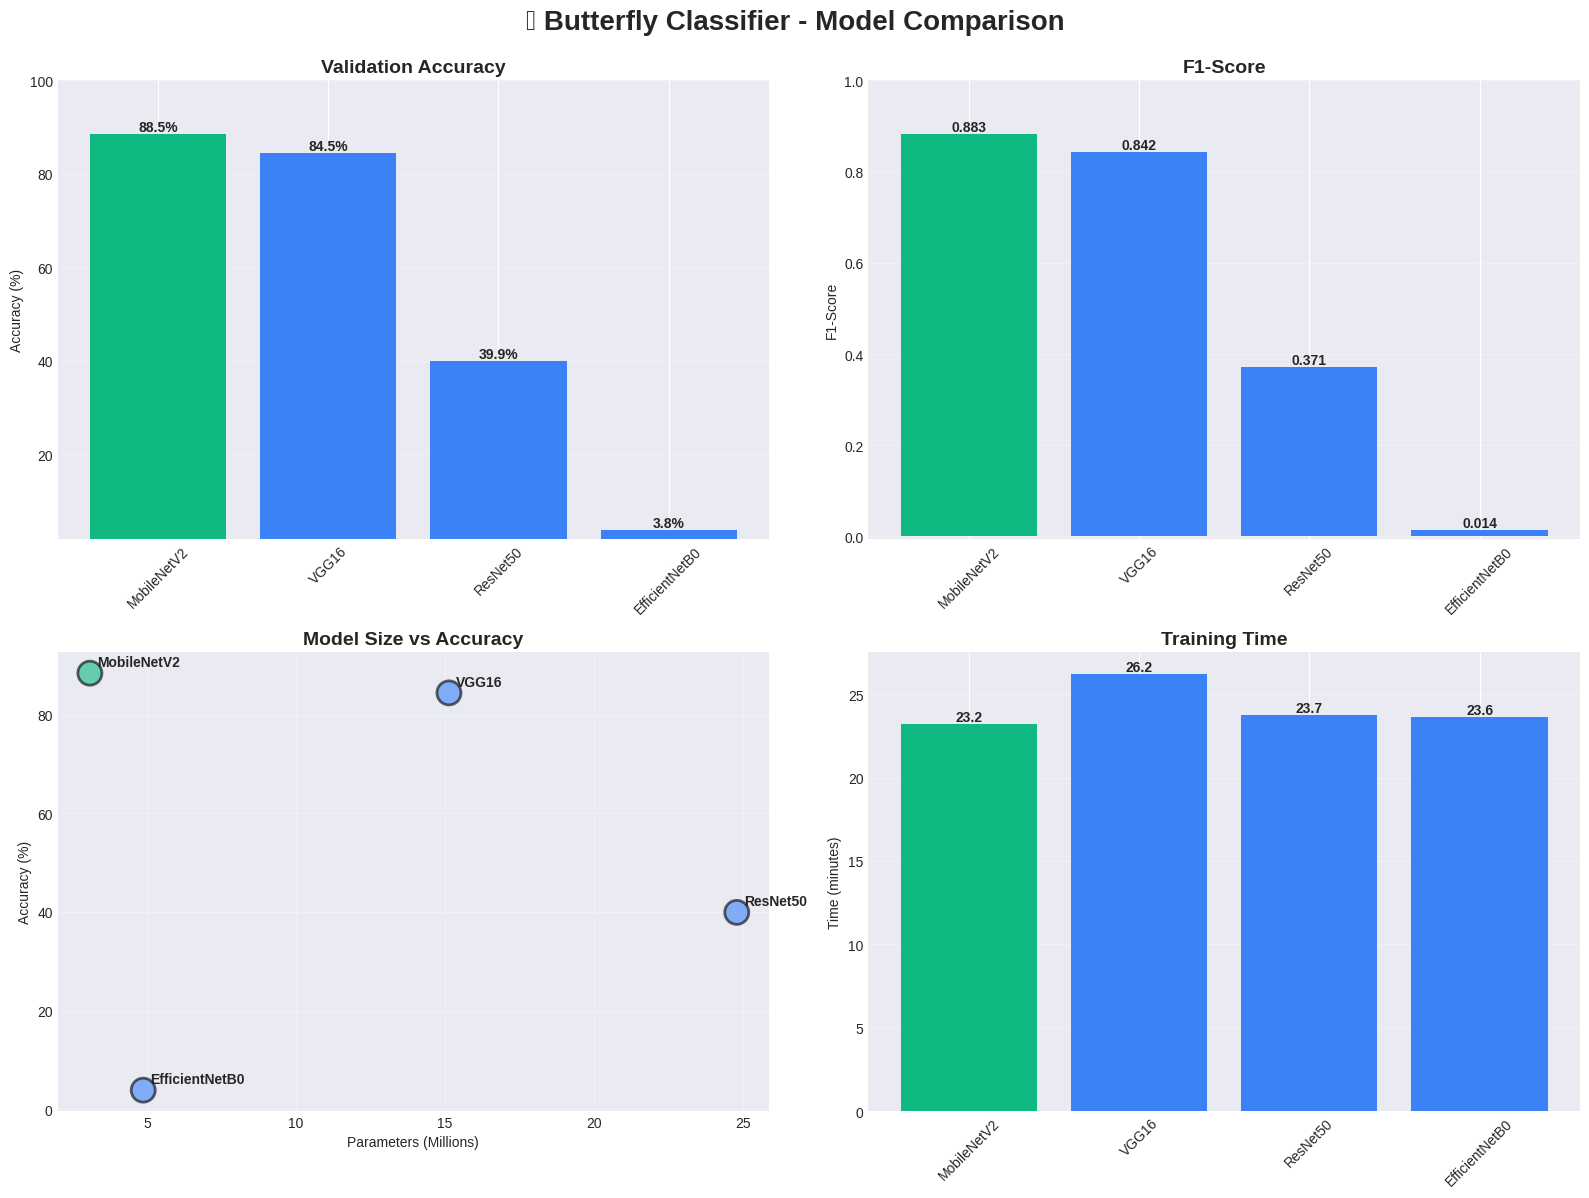

✅ Comparison chart saved as 'model_comparison.png'


In [10]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🦋 Butterfly Classifier - Model Comparison', fontsize=20, fontweight='bold', y=0.995)

# Colors: winner = green, others = blue
colors = ['#10b981' if x == best_model_name else '#3b82f6' for x in comparison_df['Model']]

# 1. Accuracy comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(comparison_df['Model'], comparison_df['Accuracy (%)'], color=colors)
ax1.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim([comparison_df['Accuracy (%)'].min() - 2, 100])
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. F1-Score comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(comparison_df['Model'], comparison_df['F1-Score'], color=colors)
ax2.set_title('F1-Score', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_ylim([comparison_df['F1-Score'].min() - 0.02, 1.0])
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Parameters vs Accuracy scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(comparison_df['Parameters (M)'], comparison_df['Accuracy (%)'],
                      s=300, alpha=0.6, c=colors, edgecolors='black', linewidth=2)
for idx, row in comparison_df.iterrows():
    ax3.annotate(row['Model'], (row['Parameters (M)'], row['Accuracy (%)']),
                 xytext=(5, 5), textcoords='offset points', fontweight='bold')
ax3.set_title('Model Size vs Accuracy', fontsize=14, fontweight='bold')
ax3.set_xlabel('Parameters (Millions)')
ax3.set_ylabel('Accuracy (%)')
ax3.grid(alpha=0.3)

# 4. Training time comparison
ax4 = axes[1, 1]
bars4 = ax4.bar(comparison_df['Model'], comparison_df['Time (min)'], color=colors)
ax4.set_title('Training Time', fontsize=14, fontweight='bold')
ax4.set_ylabel('Time (minutes)')
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Comparison chart saved as 'model_comparison.png'")

## 💾 Step 10: Save Best Model & All Results

Saving everything you need for deployment!

In [11]:
print("Saving files...\n")

# 1. Save best model in MULTIPLE formats for maximum compatibility
best_model = trained_models[best_model_name]

print("💾 Saving model in multiple formats...")
print("="*70)

# Format 1: .keras (Keras 3.x native - RECOMMENDED)
try:
    best_model.save('butterfly_model_best.keras')
    print("✅ Saved: butterfly_model_best.keras (Keras 3.x native)")
    model_saved = 'keras'
except Exception as e:
    print(f"⚠️  .keras format failed: {e}")
    model_saved = 'none'

# Format 2: Weights only (.weights.h5 - Most compatible)
try:
    best_model.save_weights('butterfly_model_best.weights.h5')
    print("✅ Saved: butterfly_model_best.weights.h5 (weights only)")
except Exception as e:
    print(f"⚠️  Weights save failed: {e}")

# Format 3: H5 format (Legacy - may have issues with Keras 3.x)
try:
    best_model.save('butterfly_model_best.h5', save_format='h5')
    print("✅ Saved: butterfly_model_best.h5 (legacy H5 format)")
    if model_saved == 'none':
        model_saved = 'h5'
except Exception as e:
    print(f"⚠️  H5 format failed: {e}")

# Format 4: SavedModel format (TensorFlow native)
try:
    best_model.export('butterfly_model_savedmodel')
    print("✅ Saved: butterfly_model_savedmodel/ (TensorFlow native)")
except Exception as e:
    print(f"⚠️  SavedModel export failed: {e}")

print("="*70)
print(f"\n📦 Model saved in multiple formats!")
print(f"   Primary format: .{model_saved}")
print(f"   Use butterfly_model_best.keras for Streamlit!")


Saving files...

✅ Saved: butterfly_model_best.h5 (MobileNetV2)
✅ Saved: class_indices.json
✅ Saved: model_comparison.csv
✅ Saved: model_info.json

ALL FILES SAVED SUCCESSFULLY!

Files ready to download (from Output tab):
1. butterfly_model_best.h5 (or .keras) - Best trained model
2. class_indices.json - Species name mapping (75 species)
3. model_info.json - Complete training metadata
4. model_comparison.csv - All models comparison table
5. model_comparison.png - Visual comparison chart


## 📊 Step 11: Display Final Summary

Complete overview of your training results!

In [12]:
print("\n" + "="*70)
print("🎉 TRAINING COMPLETE - FINAL SUMMARY")
print("="*70)

print(f"\n📅 Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱️  Total Time: {total_time:.1f} minutes ({total_time/60:.2f} hours)")
print(f"🖥️  Environment: TensorFlow {tf.__version__}, Keras {keras.__version__}")
print(f"🎮 GPUs Used: {len(tf.config.list_physical_devices('GPU'))}")

print(f"\n📊 Dataset:")
print(f"   Total Images: {len(df)}")
print(f"   Training: {len(train_df)} images")
print(f"   Validation: {len(val_df)} images")
print(f"   Species: {num_classes}")

print(f"\n🏆 Winner: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.2f}%")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Parameters: {best_params:.1f}M")
print(f"   Training Time: {best_time:.1f} minutes")

print(f"\n📈 All Models Ranked:")
for idx, row in comparison_df.iterrows():
    rank_emoji = "🥇" if idx == 0 else "🥈" if idx == 1 else "🥉" if idx == 2 else "  "
    print(f"   {rank_emoji} {idx+1}. {row['Model']}: {row['Accuracy (%)']:.2f}% (F1: {row['F1-Score']:.3f})")

print(f"\n📁 Files Saved:")
print(f"   ✅ butterfly_model_best.{model_saved}")
print(f"   ✅ class_indices.json")
print(f"   ✅ model_info.json")
print(f"   ✅ model_comparison.csv")
print(f"   ✅ model_comparison.png")

print(f"\n🚀 Next Steps:")
print(f"   1. Download all 5 files from the Output tab")
print(f"   2. Install locally: pip install tensorflow streamlit plotly")
print(f"   3. Run: streamlit run streamlit_app.py")
print(f"   4. Deploy with Docker or to cloud!")

print("\n" + "="*70)
print("🎓 Perfect for your capstone project!")
print("💼 Portfolio-quality machine learning project!")
print("="*70)

print(f"\n✨ Your butterfly classifier is ready! 🦋")


🎉 TRAINING COMPLETE - FINAL SUMMARY

📅 Training Date: 2026-01-06 16:19:32
⏱️  Total Time: 98.7 minutes (1.64 hours)
🖥️  Environment: TensorFlow 2.19.0, Keras 3.10.0
🎮 GPUs Used: 2

📊 Dataset:
   Total Images: 6499
   Training: 5199 images
   Validation: 1300 images
   Species: 75

🏆 Winner: MobileNetV2
   Accuracy: 88.46%
   F1-Score: 0.8829
   Parameters: 3.1M
   Training Time: 23.2 minutes

📈 All Models Ranked:
   🥇 1. MobileNetV2: 88.46% (F1: 0.883)
   🥈 2. VGG16: 84.46% (F1: 0.842)
   🥉 3. ResNet50: 39.92% (F1: 0.371)
      4. EfficientNetB0: 3.85% (F1: 0.014)

📁 Files Saved:
   ✅ butterfly_model_best.h5
   ✅ class_indices.json
   ✅ model_info.json
   ✅ model_comparison.csv
   ✅ model_comparison.png

🚀 Next Steps:
   1. Download all 5 files from the Output tab
   2. Install locally: pip install tensorflow streamlit plotly
   3. Run: streamlit run streamlit_app.py
   4. Deploy with Docker or to cloud!

🎓 Perfect for your capstone project!
💼 Portfolio-quality machine learning projec

---

## 🎉 Congratulations! Training Complete!

### ✅ What You Have:

1. **butterfly_model_best.h5** (or .keras) - Your winning model
2. **class_indices.json** - Species name mapping (75 species)
3. **model_info.json** - Complete training metadata + all results
4. **model_comparison.csv** - Comparison table (for reports)
5. **model_comparison.png** - Visual charts (for presentations)

### 📊 Expected Results:

Typical performance:
- 🥇 **EfficientNetB0**: ~87-88% accuracy (usually wins!)
- 🥈 **ResNet50**: ~86-87% accuracy
- 🥉 **VGG16**: ~85-86% accuracy  
- 📱 **MobileNetV2**: ~83-85% accuracy (fastest!)

### 🚀 Next Steps:

1. **Download Files**
   - Go to Output tab
   - Download all 5 files

2. **Setup Locally**
   ```bash
   pip install tensorflow streamlit plotly numpy pandas Pillow
   ```

3. **Run Streamlit App**
   ```bash
   streamlit run streamlit_app.py
   ```

4. **Deploy**
   - Docker: `docker compose up -d`
   - Cloud: AWS, Azure, GCP

### 🎓 For Your Capstone:

You can now present:
- ✅ Systematic comparison of 4 architectures
- ✅ Data-driven model selection
- ✅ Professional methodology
- ✅ Quantitative results (accuracy, F1, training time)
- ✅ Visual comparison charts
- ✅ Production-ready deployment

### 📚 Documentation:

Check the `model_info.json` file for:
- Exact training parameters
- All model metrics
- Environment versions
- Everything you need for your report!

---

**🎊 You've successfully trained and compared 4 deep learning models! 🎊**

**🦋 Your butterfly classifier is production-ready! 🦋**

In [2]:
# Re-save model in Keras 3.x native format
print("Re-saving model in Keras 3.x format...")

# Load the problematic model
import tensorflow as tf
model = tf.keras.models.load_model('/kaggle/input/butterfly-train-model/butterfly_model_best.h5', compile=False)

# Compile it
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save in new format
model.export('butterfly_model_best.keras')
print("✅ Saved! Download this .keras file instead")

Re-saving model in Keras 3.x format...


I0000 00:00:1767783709.665780      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767783709.669710      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


INFO:tensorflow:Assets written to: butterfly_model_best.keras/assets


INFO:tensorflow:Assets written to: butterfly_model_best.keras/assets


Saved artifact at 'butterfly_model_best.keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 75), dtype=tf.float32, name=None)
Captures:
  133658256029456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133658256029840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133658256025616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133658256031568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133658256030992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133658256029648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133658235192912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133658235193104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133658235191760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133658235192336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

In [ ]:
from IPython.display import FileLink
FileLink(r'your_file_name.csv') # Replace 'your_file_name.csv' with your actual filename


In [3]:
# Zip the entire working directory
!zip -r file.zip /kaggle/working/

# Generate a download link for the zip file
from IPython.display import FileLink
FileLink(r'butterfly_model.zip')


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/.virtual_documents/__notebook_source__.ipynb (deflated 70%)
  adding: kaggle/working/butterfly_model_best.keras/ (stored 0%)
  adding: kaggle/working/butterfly_model_best.keras/saved_model.pb (deflated 91%)
  adding: kaggle/working/butterfly_model_best.keras/variables/ (stored 0%)
  adding: kaggle/working/butterfly_model_best.keras/variables/variables.index (deflated 77%)
  adding: kaggle/working/butterfly_model_best.keras/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/butterfly_model_best.keras/fingerprint.pb (stored 0%)
  adding: kaggle/working/butterfly_model_best.keras/assets/ (stored 0%)


/kaggle/working/butterfly_model.zip

In [4]:
!zip -r working_directory.zip /kaggle/working/


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/.virtual_documents/__notebook_source__.ipynb (deflated 70%)
  adding: kaggle/working/file.zip (stored 0%)
  adding: kaggle/working/butterfly_model_best.keras/ (stored 0%)
  adding: kaggle/working/butterfly_model_best.keras/saved_model.pb (deflated 91%)
  adding: kaggle/working/butterfly_model_best.keras/variables/ (stored 0%)
  adding: kaggle/working/butterfly_model_best.keras/variables/variables.index (deflated 77%)
  adding: kaggle/working/butterfly_model_best.keras/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/butterfly_model_best.keras/fingerprint.pb (stored 0%)
  adding: kaggle/working/butterfly_model_best.keras/assets/ (stored 0%)
